In [1]:
include("BFFPSV18.jl")

add_time! (generic function with 2 methods)

## Model description

In [2]:
# ======================================
# Model: Motor (8 variables, 2 inputs)
# ======================================
using SparseArrays

# =====================
# Problem specification
# =====================
I = [1, 2, 2, 3, 3, 3, 3, 4, 5, 6, 6, 7, 7, 7, 7, 8]
J = [2, 3, 2, 1, 2, 3, 4, 1, 6, 7, 6, 5, 6, 7, 8, 5]
vals = [1, 8487.2, -1.0865, -2592.1, -21.119, -698.91, -141399.0, 1.0, 1.0,
       8487.2, -1.0865, -2592.1, -21.119, -698.91, -141399.0, 1.0]
A = sparse(I, J, vals)

# input set
B = sparse([4, 8], [1, 2], [-1.0, -1.0])
U = Hyperrectangle([0.23, 0.3], [0.07, 0.1])

# instantiate continuous LTI system
S = ConstrainedLinearControlContinuousSystem(A, B, nothing, U);

## Reachability settings

In [3]:
# initial set
X0 = Hyperrectangle([0.00225, 0.0, 0.0, 0.0, 0.00125, 0.0, 0.0, 0.0],
                    [0.00025, 0.0, 0.0, 0.0, 0.00025, 0.0, 0.0, 0.0])

P = InitialValueProblem(S, X0);

In [4]:
Matrix(A)

8×8 Array{Float64,2}:
     0.0    1.0        0.0         0.0      0.0    0.0        0.0         0.0
     0.0   -1.0865  8487.2         0.0      0.0    0.0        0.0         0.0
 -2592.1  -21.119   -698.91  -141399.0      0.0    0.0        0.0         0.0
     1.0    0.0        0.0         0.0      0.0    0.0        0.0         0.0
     0.0    0.0        0.0         0.0      0.0    1.0        0.0         0.0
     0.0    0.0        0.0         0.0      0.0   -1.0865  8487.2         0.0
     0.0    0.0        0.0         0.0  -2592.1  -21.119   -698.91  -141399.0
     0.0    0.0        0.0         0.0      1.0    0.0        0.0         0.0

In [5]:
# two partition strategies
partition_2D = [(2*i-1:2*i) for i in 1:4] # 2D blocks
partition_1D = [[i] for i in 1:8]; # 1D blocks

In [6]:
# UNIFORM 2D partition over all variables
opts_2D = Options(:T => 20.0,
                  :δ => 0.001,
                  :N => 20_000,
                  :vars=>[1, 2, 3, 4, 5, 6, 7, 8],
                  :partition => partition_2D,
                  :set_type => Hyperrectangle{Float64, Vector{Float64}, Vector{Float64}},
                  :row_blocks => [[1, 2], [3, 4], [5, 6], [7, 8]],
                  :column_blocks => partition_2D,
                  :num_type => Float64,
                  :sparse => false,
                  :block_indices => [1, 2, 3, 4]); # indices of blocks that need to be computed

In [7]:
# UNIFORM 2D partition over all variables
opts_1D = Options(:T => 20.0,
                  :δ => 0.001,
                  :N => 20_000,
                  :vars=>[1, 2, 3, 4, 5, 6, 7, 8],
                  :partition => partition_1D,
                  :set_type => Interval{Float64, IA.Interval{Float64}},
                  :row_blocks => partition_1D,
                  :column_blocks => partition_1D,
                  :num_type => Float64,
                  :sparse => false,
                  :block_indices => [i for i in 1:8]); # indices of blocks that need to be computed

### Schur transformation

In [8]:
using LinearAlgebra

In [16]:
F = schur(Matrix(A))

# A = Tsc * Asc * Tsc'
Asc = F.Schur

8×8 Array{Float64,2}:
 -299.935  -8410.38   -1215.2       …      0.0           0.0     
    0.0     -200.099   -734.815           -0.0          -0.0     
    0.0        0.0      -99.9813           0.0           0.0     
    0.0        0.0       -0.504985         0.0           0.0     
    0.0        0.0        0.0          -1215.2        4982.57    
    0.0        0.0        0.0       …   -734.815         1.3994e5
    0.0        0.0        0.0            -99.9813    19801.7     
    0.0        0.0        0.0             -0.504985    -99.9813  

In [17]:
Asc[[1, 3], :]

2×8 Array{Float64,2}:
 -299.935  -8410.38  -1215.2      4982.57  0.0  0.0  0.0  0.0
    0.0        0.0     -99.9813  19801.7   0.0  0.0  0.0  0.0

In [18]:
Matrix(A[[1, 3], :])

2×8 Array{Float64,2}:
     0.0    1.0       0.0         0.0  0.0  0.0  0.0  0.0
 -2592.1  -21.119  -698.91  -141399.0  0.0  0.0  0.0  0.0

In [19]:
A3 = A * A * A
Matrix(A3[[1, 3], :])

2×8 Array{Float64,2}:
 -2.19997e7  -179240.0        -5.94101e6  -1.20008e9   0.0  0.0  0.0  0.0
 -7.0274e8        -4.87371e6  -1.12658e8  -4.37254e10  0.0  0.0  0.0  0.0

In [20]:
A3sc = Asc * Asc * Asc
Matrix(A3sc[[1, 3], :])

2×8 Array{Float64,2}:
 -2.69825e7  -1.59812e9  -3.2583e9   8.41187e11  0.0  0.0  0.0  0.0
  0.0         0.0         1.99987e6  3.95821e8   0.0  0.0  0.0  0.0

In [21]:
Tsc = F.vectors

8×8 Array{Float64,2}:
 -0.00333197   0.140218    -0.990025    …   0.0         0.0        
  0.999375    -0.0343753   -0.00823126      0.0         0.0        
 -0.0351897   -0.989523    -0.140019        0.0         0.0        
  1.1109e-5   -0.00116767   0.0132985       0.0         0.0        
  0.0         -0.0          0.0            -0.990025    0.0133308  
  0.0         -0.0          0.0         …  -0.00823126  5.8228e-5  
  0.0         -0.0          0.0            -0.140019    0.000707071
  0.0         -0.0          0.0             0.0132985   0.999911   

In [22]:
norm(Tsc * Asc * Tsc' - A)

7.886665287864832e-11

In [23]:
norm(inv(Tsc) - Tsc') # the inverse of T is its transpose

2.435561991113167e-15

Let $A = T S T'$. Then, $x' = Ax + Bu$ transforms into

$T^T x' = ST^T x + T^T B u$, defining $y = T^T x$, then we consider the system

$$
y' = Sy + B' u,
$$
where $B' = T^T B$.

In [24]:
# recall that for Schur matrices, inv(T) == T'
Tsc_inv = copy(transpose(Tsc))

# apply transformation to the initial states
X0sc = Tsc_inv * P.x0

# apply transformation to the inputs
Bsc = Tsc_inv * P.s.B
Usc = P.s.U

Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}([0.23, 0.3], [0.07, 0.1])

In [25]:
S_schur = ConstrainedLinearControlContinuousSystem(Asc, Bsc, nothing, Usc)
P_schur = InitialValueProblem(S_schur, X0sc);

## Results

In [14]:
using Plots, LaTeXStrings

### Uniform 2D partition, no coordinate transformation

In [26]:
sol = solve_BFFPSV18(P, opts_2D);

In [27]:
sol_proj = [project(set(x), [1, 2], LazySets.LinearMap) for x in sol];

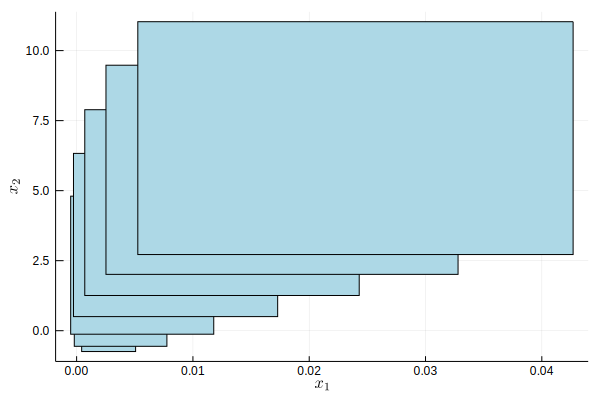

In [28]:
plot([x for x in sol_proj[1:10]], color=:lightblue, xlab=L"x_1", ylab=L"x_2", alpha=1.0)

### Uniform 2D partition with Schur transformation

In [29]:
sol = solve_BFFPSV18(P_schur, opts_2D);

In [30]:
# revert transformation
sol = [Tsc * set(x) for x in sol];

In [31]:
sol_proj = [project(x, [1, 2], LazySets.LinearMap) for x in sol];

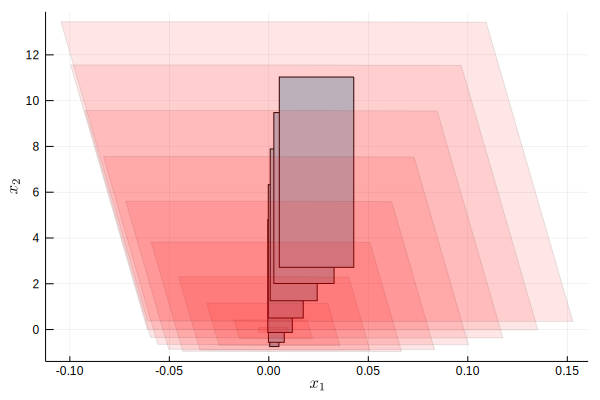

In [32]:
plot!([x for x in sol_proj[1:1:10]], color=:red, xlab=L"x_1", ylab=L"x_2", alpha=.1)

### Discussion

In [33]:
δ = 0.001
ϕ = exp(Matrix(A) * δ)

8×8 Array{Float64,2}:
  0.996878      0.000973576  0.00335549  …  0.0            0.0     
 -8.86569       0.924956     5.91775        0.0            0.0     
 -1.8644       -0.0157699    0.438394       0.0            0.0     
  0.000999194   4.9316e-7    1.18764e-6     0.0            0.0     
  0.0           0.0          0.0            0.00335549    -0.167932
  0.0           0.0          0.0         …  5.91775     -474.463   
  0.0           0.0          0.0            0.438394     -98.652   
  0.0           0.0          0.0            1.18764e-6     0.999957

In [34]:
ϕ[[1, 3], :]

2×8 Array{Float64,2}:
  0.996878   0.000973576  0.00335549   -0.167932  0.0  0.0  0.0  0.0
 -1.8644    -0.0157699    0.438394    -98.652     0.0  0.0  0.0  0.0

In [35]:
ϕsc = exp(Matrix(Asc) * δ)

8×8 Array{Float64,2}:
 0.740866  -6.55262   1.61703      …   0.0       0.0             0.0     
 0.0        0.81865  -0.662525         0.0       0.0             0.0     
 0.0        0.0       0.900334         0.0       0.0             0.0     
 0.0        0.0      -0.000456177      0.0       0.0             0.0     
 0.0        0.0       0.0             -6.55262   1.61703      -470.765   
 0.0        0.0       0.0          …   0.81865  -0.662525      113.923   
 0.0        0.0       0.0              0.0       0.900334       17.8878  
 0.0        0.0       0.0              0.0      -0.000456177     0.900334

In [ ]:
ϕsc[[1, 3], :]

Here, the matrix exponential of the Schur-transformed system has more zeros as expected. On the other hand, the figures are also substantially bigger and this fact seems to have a negative impact on the decomposition error.

Does the situation change if we use one-dimensional blocks?

### Uniform 1D partition, no coordinate transformation

In [36]:
sol = solve_BFFPSV18(P, opts_1D);

In [37]:
sol_proj = [project(set(x), [1, 2], LazySets.LinearMap) for x in sol];

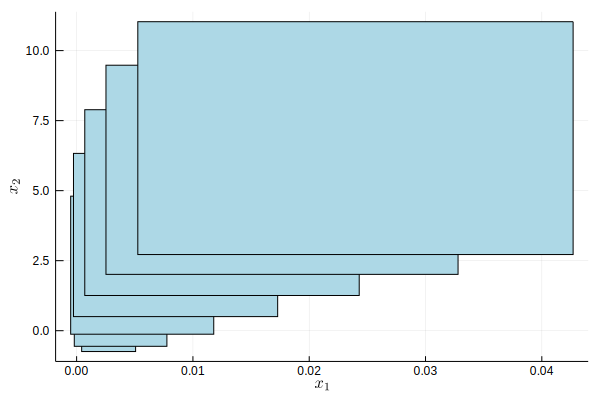

In [38]:
plot([x for x in sol_proj[1:10]], color=:lightblue, xlab=L"x_1", ylab=L"x_2", alpha=1.0)

### Uniform 1D partition, with Schur transformation

In [39]:
sol = solve_BFFPSV18(P_schur, opts_1D);

In [40]:
# revert transformation
sol = [Tsc * set(x) for x in sol];

In [41]:
sol_proj = [project(x, [1, 2], LazySets.LinearMap) for x in sol];

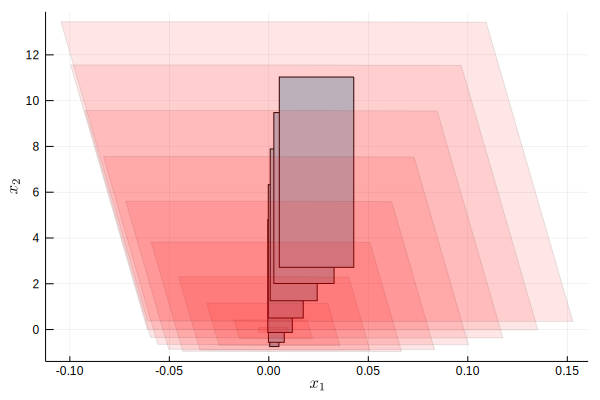

In [42]:
plot!([x for x in sol_proj[1:1:10]], color=:red, xlab=L"x_1", ylab=L"x_2", alpha=.1)

### Schur transformation to the matrix exponential

Similarity transformations have been applied so far in the coefficients matrix `A`. This is in fact the way it has been implemented in Reachability.jl

However, in the paper we suggest to apply a similarity transformation past the discretization, ie. to the matrix exponential.

In [9]:
function transform_schur(P)
    # apply Schur transformation to the system
    F = schur(Matrix(P.s.A))
    Tsc = F.vectors
    Asc = F.Schur

    # recall that for Schur matrices, inv(T) == T'
    Tsc_inv = copy(transpose(Tsc))

    # apply transformation to the initial states
    X0sc = Tsc_inv * P.x0

    # apply transformation to the inputs
    Bsc = Tsc_inv * P.s.B
    Usc = P.s.U
    Ssc = ConstrainedLinearControlContinuousSystem(Asc, Bsc, nothing, Usc)
    Psc = InitialValueProblem(Ssc, X0sc)
    
    return Psc, Tsc
end

transform_schur (generic function with 1 method)

In [10]:
function solve_BFFPSV18_Schur(P::IVP{<:CLCCS, <:LazySet}, opts)
    
    # unwrap some options
    vars = opts[:vars]
    δ = opts[:δ]
    N = opts[:N]
    NUM = opts[:num_type]
    ST = opts[:set_type]
    partition = opts[:partition]
    block_indices = opts[:block_indices]
    column_blocks = opts[:column_blocks]
    row_blocks = opts[:row_blocks]
    sp = opts[:sparse]

    # normalize and discretize system
    Pdiscr = discretization(P, δ)
    
    # apply Schur transformation
    Pdiscr, Tsc = transform_schur(Pdiscr)
    
    Ω0 = Pdiscr.x0 # bloated initial set
    # decompose into a cartesian product
    Ω0deco = _decompose(Ω0, partition, ST)
    ϕ = Pdiscr.s.A
    Xhat0 = Ω0deco.array # pointer to the CPA array    

    # preallocate output flowpipe
    SRS = SparseReachSet{CartesianProductArray{NUM, ST}}
    res = Vector{SRS}(undef, N)
    
    # compute flowpipe
    U = inputset(Pdiscr.s).U # we are assuming that this input is CONSTANT and the system
    # has been normalized to be of the form x' = Ax + u, u in U
 
    if sp
        # SPARSE
        ϕ = sparse(ϕ)
        reach_inhomog_sparse!(res, ϕ, Xhat0, U, δ, N, vars, block_indices, row_blocks, column_blocks, NUM, ST)
    else
        # DENSE
        reach_inhomog!(res, ϕ, Xhat0, U, δ, N, vars, block_indices, row_blocks, column_blocks, NUM, ST)
    end
    
    # revert transformation
    res = [Tsc * set(x) for x in res]
    
    return res
end

solve_BFFPSV18_Schur (generic function with 1 method)

In [11]:
sol = solve_BFFPSV18_Schur(P, opts_1D);

In [12]:
sol_proj = [project(x, [1, 2], LazySets.LinearMap) for x in sol];

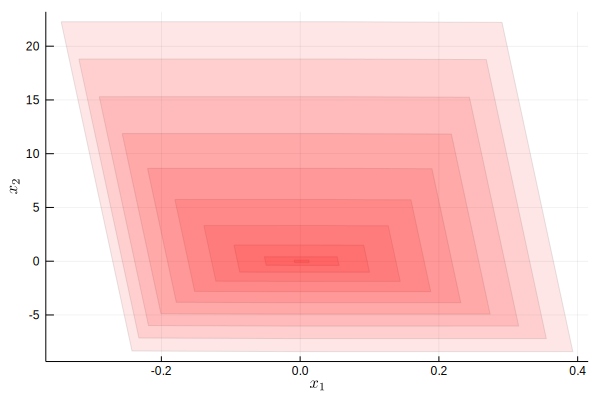

In [15]:
plot([x for x in sol_proj[1:1:10]], color=:red, xlab=L"x_1", ylab=L"x_2", alpha=.1)

### Discussion

It doesn't help to transform the exponential matrix; actually it gets worse than transforming the system's matrix.

The results obtained suggest to reformulate the sentence in the conclusion that refers to the similarity transformations as follows:

*Similarity transformations, such as Schur or Jordan transformations, can be applied to the system's dynamics. Since the number of non-zero blocks would change, as well as the matrix values, this will have an impact on the accumulated error, on the performance or both. Characterizing the advantage of using similarity transformations for a given dynamic matrix, initial states, and inputs is left for future study.*